# WE WILL NOW TRAIN A CLASSIFIER USING CNN

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms
from torch import nn
import torchvision
from torchsummary import summary
from torch.utils.data import TensorDataset,DataLoader,Dataset
import tensorflow as tf
plt.rcParams['image.cmap']='gray'
%matplotlib inline
torch.manual_seed(1000)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

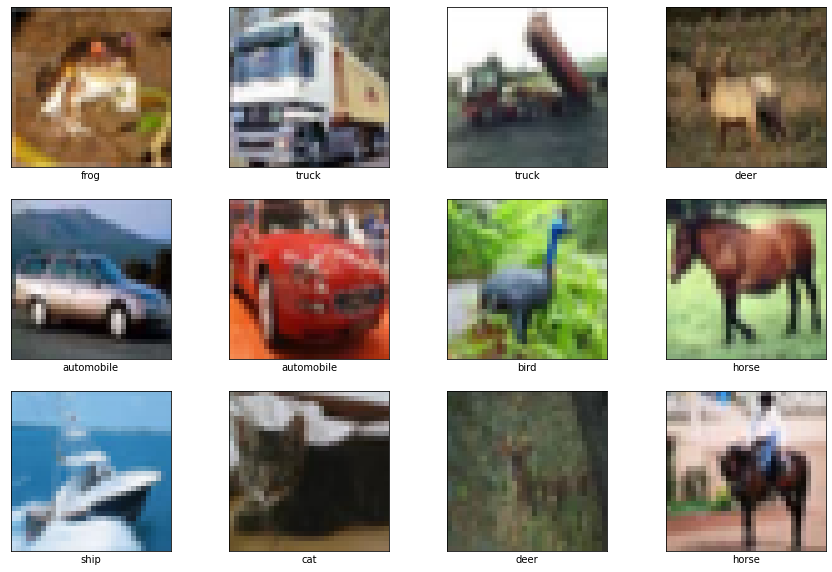

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [6]:
def load_data(features,labels, batch_size):
    features=torch.Tensor(features)
    labels=torch.Tensor(labels)
    dataset=TensorDataset(*(features,labels))
    dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
    return dataloader

In [7]:
batch_size=100
train_data_loader=load_data(train_images,train_labels,batch_size)
test_data_loader=load_data(test_images,test_labels,batch_size)

# Defining the model

In [8]:
class my_Model(nn.Module):
    def __init__(self):
        super().__init__()
        #layer2
        self.c1=nn.Conv2d(3,96,kernel_size=3,padding=1)
        self.b1=nn.BatchNorm2d(96)
        self.relu=nn.ReLU()
        self.m1=nn.MaxPool2d(kernel_size=3,stride=2)
        #layer2
        self.c2=nn.Conv2d(96,38,kernel_size=3,padding=1)
        self.b2=nn.BatchNorm2d(38)
        self.m2=nn.MaxPool2d(kernel_size=3,stride=2)
        #layer3
        self.c3=nn.Conv2d(38,38,kernel_size=3,padding=1)
        self.b3=nn.BatchNorm2d(38)
        self.m3=nn.MaxPool2d(kernel_size=3,stride=2)
        self.flatten=nn.Flatten()
        self.l1=nn.Linear(342,40)
        self.b4=nn.BatchNorm1d(40)
        self.l2=nn.Linear(40,40)
        self.drop=nn.Dropout(p=0.5)
        self.l3=nn.Linear(40,10)
        self.softmax=nn.Softmax()
        
        
    def forward(self,x):
        x=x.reshape(100,3,32,32)
        #layer1
        x=self.b1(self.c1(x))
        x=self.m1(self.relu(x))
        #layer2
        x=self.b2(self.c2(x))
        x=self.m2(self.relu(x))    
        #layer3
        x=self.b3(self.c3(x))
        x=self.m3(self.relu(x))  
        #dense layer
        x=self.l1(self.flatten(x))
        x=self.relu(self.b4(x))
        x=self.drop(self.relu(self.l2(x)))
        #output=self.softmax(self.l3(x))
        return x# output
model=my_Model()       

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
for x,y in train_data_loader:
    x=x.reshape(100,3,32,32)
    outputs = model(x)
    print(outputs.size())
    print(y.size())
    loss = criterion(outputs, torch.max(y,1)[1])
    break

torch.Size([100, 40])
torch.Size([100, 1])


In [11]:
def evaluate_accuracy(output,label):
    pred = output.argmax(dim=1,keepdim=True)
    return (pred==label.float()).float().sum()

In [13]:
def Train_model(model,train_data_loader,val_data_loader,optimizer,loss_fc,epochs):
    train_loss=0.
    val_loss=0.
    train_acc=0.
    val_acc = 0.    
    for epoch in range(epochs):

        model.train()
        for inputs,targets in train_data_loader:
            optimizer.zero_grad()
            output=model(inputs)
            loss=loss_fc(output,torch.max(targets,1)[1])
            loss.backward()
            train_acc+=evaluate_accuracy(output,targets)
            train_loss+=loss
            optimizer.step()
            
        model.eval()
        for inputs,label in val_data_loader:
            output=model(inputs)
            loss=loss_fc(output,torch.max(targets,1)[1])
            val_loss+=loss
            val_acc+=evaluate_accuracy(output,label)
        # taking averages
        train_acc/=len(train_data_loader)
        train_loss/=len(train_data_loader)
        val_acc/=len(val_data_loader)
        val_loss/=len(val_data_loader)
        print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss.detach().numpy(), train_acc.detach().numpy(),
        val_loss.detach().numpy(), val_acc.detach().numpy()))
            

In [ ]:
Train_model(model=model,optimizer=optimizer,train_data_loader=train_data_loader,val_data_loader=test_data_loader
            ,epochs=5,loss_fc=criterion)